In [2]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scypy (from versions: none)
ERROR: No matching distribution found for scypy


# Data Understanding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('hotel_booking.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nBasic Information:")
print(df.info())
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))
# Check for duplicates
df.duplicated().sum()
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (119390, 36)

Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'name', 'email', 'phone-number', 'credit_card']

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119

From this first breakdown of the data we notice some things:
- The dataset presented can be considered as large, since it has 36 features and 119390 entries;
- The target variable 'is_canceled' is numerical;
- The dataset has sensitive data present that, for the problem in question, doesn’t contribute directly to the prediction task. These sensitive fields may be removed;
- The 'company' column is missing values for most entries (over 94%), suggesting it might not be useful unless imputing these values adds value.
- The 'agent' feature also has a significant number of missing values.
- The features 'country' and 'children' have smaller numbers of missing values, which could be imputed or managed through other handling methods if they are essential features.
- The date-related features like 'arrival_date_year', 'arrival_date_month' and 'arrival_date_day_of_month' can probabily be grouped together to reduce the number of features.

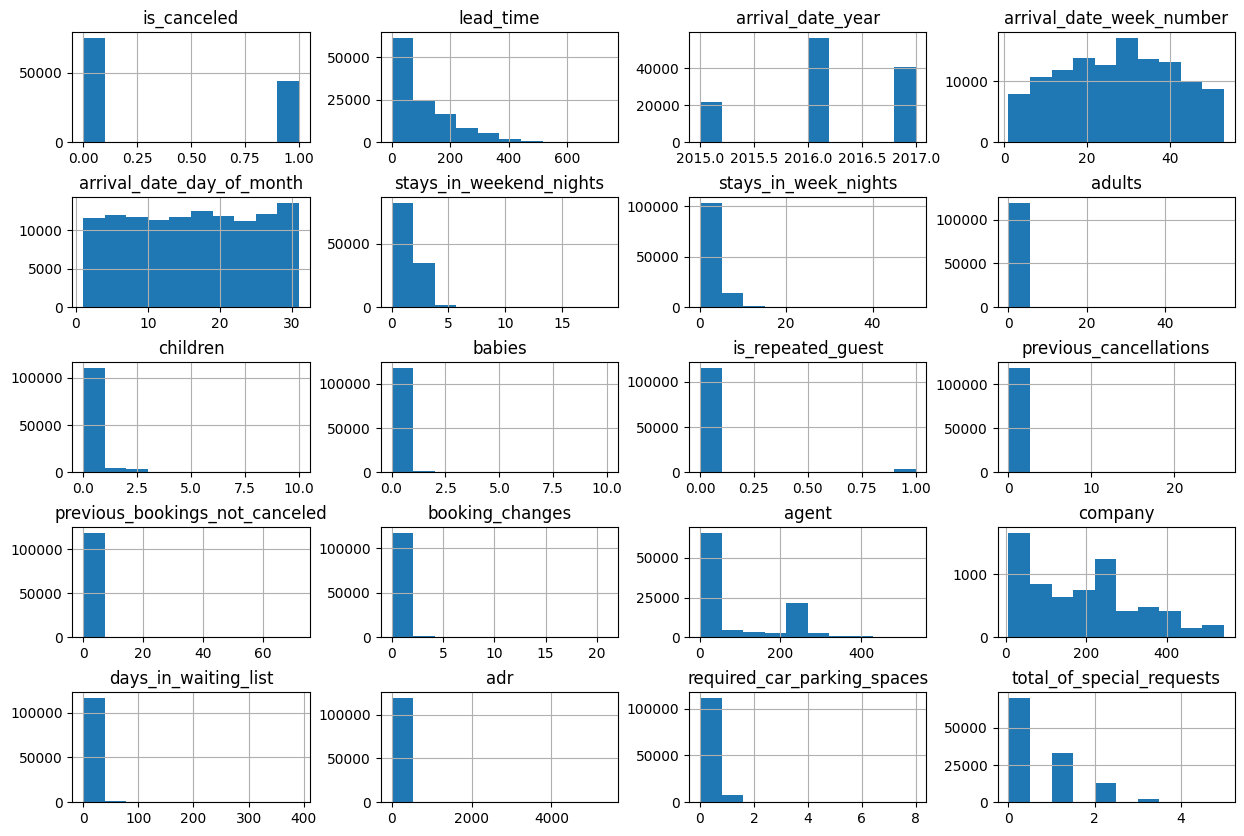

In [4]:
# Plot the duistribution of the numerical features
df.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.show()

From the previous histograms, it is possible to see the distribution of the numerical features. We see that the target variable only has two possible values, 0 and 1, which classifies the problem as a binary classification.

Looking at the 'lead_time', the distribution is right-skewed, with most bookings having shorter lead times but a few extending to longer lead times. 

The 'arrival_date_week_number' has a relatively even distribution, which indicates that bookings are spread throughout the year, while 'arrival_date_day_of_month' appears fairly uniform as well.

The stays-related are heavily skewed toward shorter stays, which is typical for many hotels. These features can also be combined in a feature for total nights stayed.

Most bookings are for a smaller number of adults, with few children or babies. This may suggest that single or couple bookings are most common, with fewer family bookings.

Very few guests are repeat customers (is_repeated_guest), and most have no previous cancellations. 

The 'lead_time' and 'adr' have different ranges of values, so a scalling ot these features might improve the performance of the models.


In [5]:
# Remove sensitive information
columns_to_drop = ['name', 'email', 'phone-number', 'credit_card']
df = df.drop(columns=columns_to_drop)

In [6]:
# Select categorical features
categorical_features = df.select_dtypes(include='object').columns.tolist()
categorical_features

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [ ]:
# Remove reservation_status_date and country from the list of categorical features since they are not wanted for the analysis
categorical_features.remove('reservation_status_date')
categorical_features.remove('country')

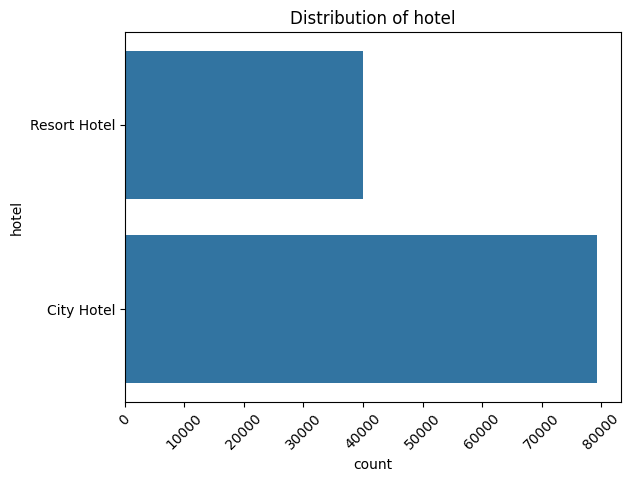

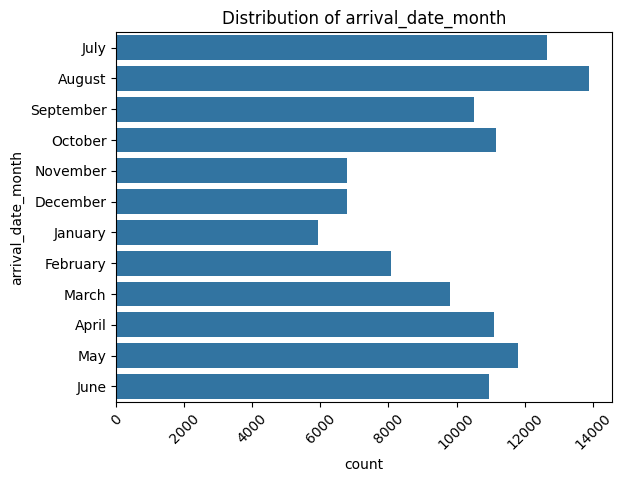

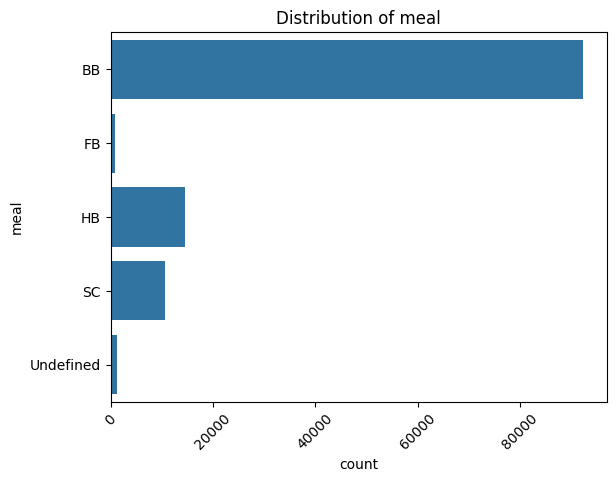

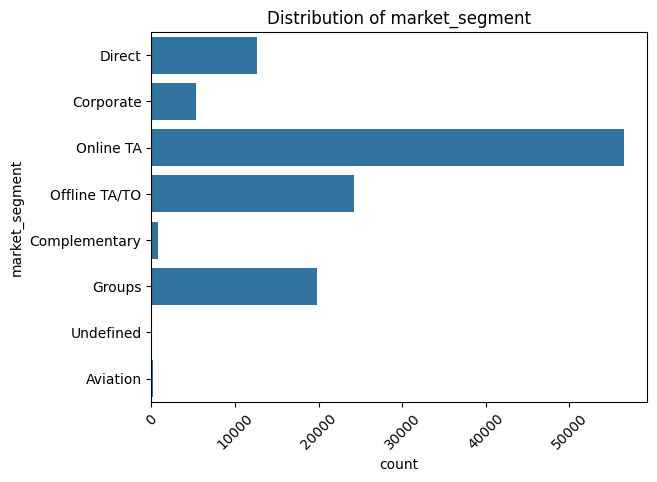

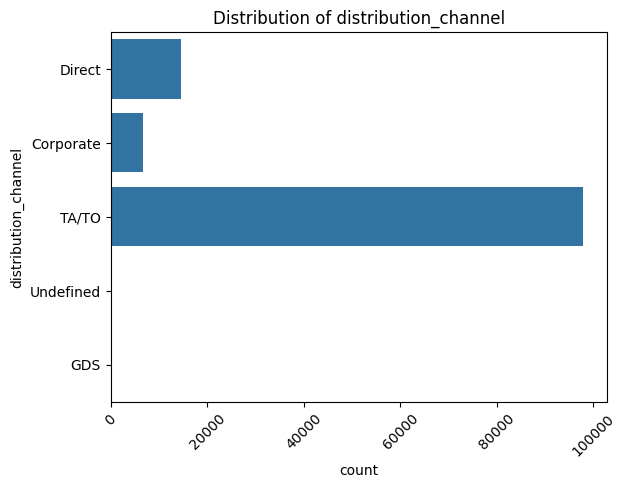

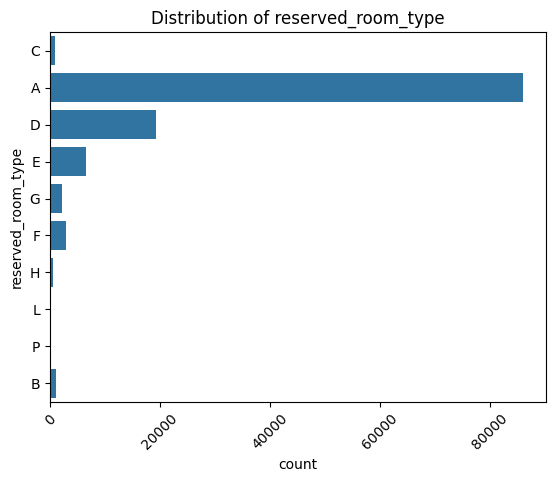

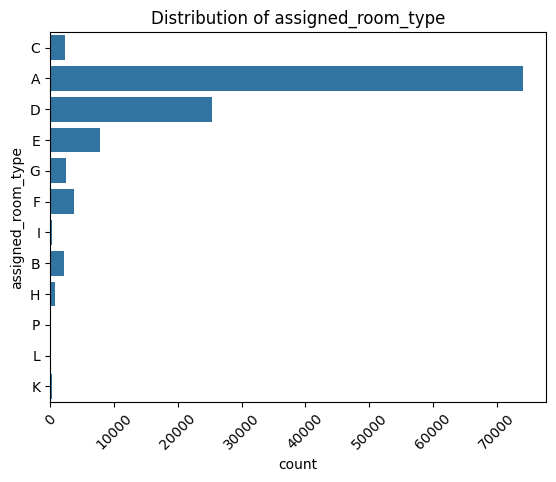

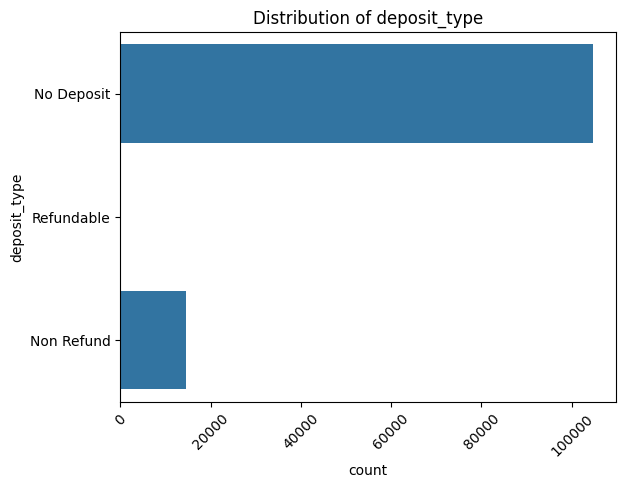

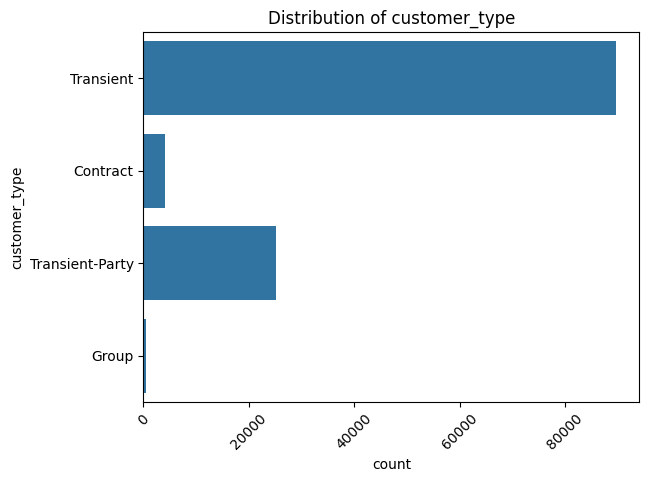

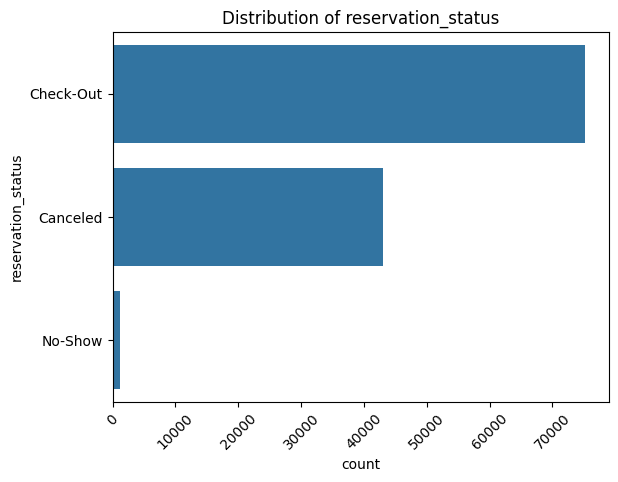

In [8]:
# Plot the distribution of the categorical features
for feature in categorical_features:
    sns.countplot(df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

From the countplots of the categorical features we can see that these features usually have a more dominant class, not following an even distribution.

Overall cancellation rate: 37.04%


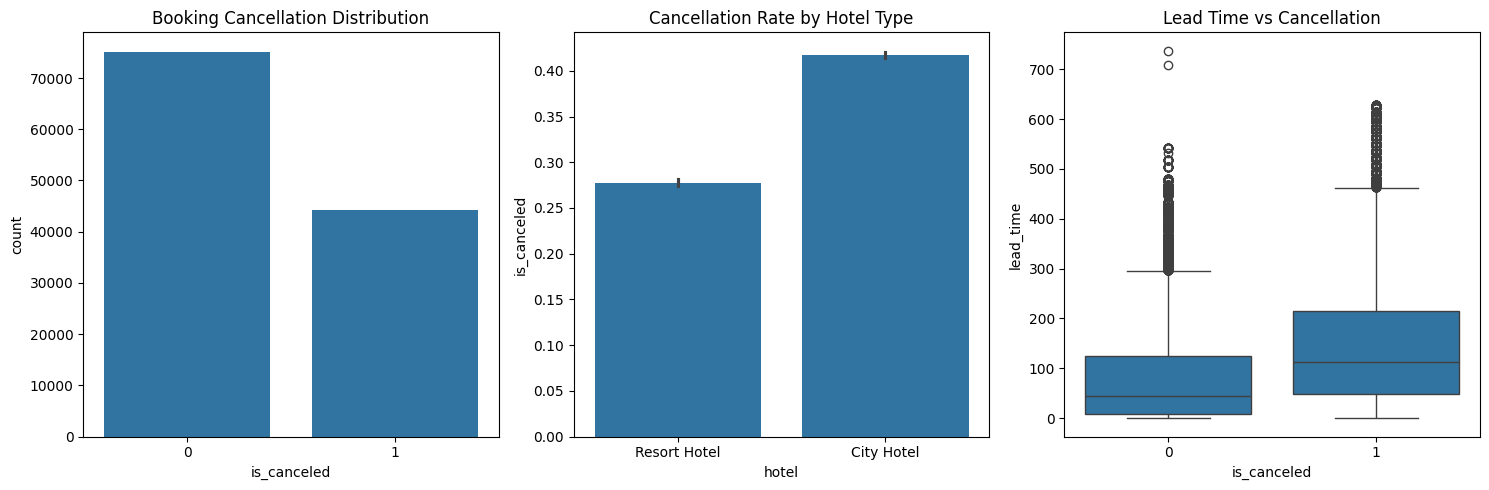


Cancellation rates by market segment:
market_segment
Undefined        1.000000
Groups           0.610620
Online TA        0.367211
Offline TA/TO    0.343160
Aviation         0.219409
Corporate        0.187347
Direct           0.153419
Complementary    0.130552
Name: is_canceled, dtype: float64

Average lead time for cancelled vs non-cancelled bookings:
is_canceled
0     79.984687
1    144.848815
Name: lead_time, dtype: float64


In [9]:
# Basic statistics about cancellations
cancellation_rate = df['is_canceled'].mean() * 100
print(f"Overall cancellation rate: {cancellation_rate:.2f}%")

# Create some initial visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Cancellation distribution
plt.subplot(131)
sns.countplot(data=df, x='is_canceled')
plt.title('Booking Cancellation Distribution')

# Plot 2: Cancellation rate by hotel type
plt.subplot(132)
sns.barplot(data=df, x='hotel', y='is_canceled')
plt.title('Cancellation Rate by Hotel Type')

# Plot 3: Lead time distribution by cancellation status
plt.subplot(133)
sns.boxplot(data=df, x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation')

plt.tight_layout()
plt.show()

# Additional insights
print("\nCancellation rates by market segment:")
print(df.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False))

print("\nAverage lead time for cancelled vs non-cancelled bookings:")
print(df.groupby('is_canceled')['lead_time'].mean())

From the previous graphics we can see:
- that there are more non-canceled bookings (labeled as 0) than canceled ones (1), which reflects the slight class imbalance in the data;
- the City Hotel has a higher cancellation rate than the Resort Hotel, indicating that guests may be more likely to cancel their bookings at City Hotels compared to Resort Hotels;
- canceled bookings (1) generally have a higher median lead time than non-canceled bookings (0), suggesting that customers with longer lead times might be more likely to cancel.
- there are also more outliers in the canceled group, indicating that some customers with very long lead times tend to cancel.

Cancellation Rates by Market Segment:
- The Undefined market segment has a 100% cancellation rate, which may indicate data issues or unique customer behavior.
- The Groups segment has the highest cancellation rate among the defined segments (61%), possibly due to the more complex logistics involved in group bookings.
- Online TA (Online Travel Agents) and Offline TA/TO (Offline Travel Agents/Tour Operators) also have relatively high cancellation rates (around 34–37%).
- Corporate, Direct, and Complementary segments have the lowest cancellation rates, which might indicate more commitment from these customers.
- These differences suggest that the market segment could be a significant feature for predicting cancellations, as customers from different segments have varying cancellation behaviors.

Average Lead Time for Canceled vs. Non-Canceled Bookings:
- The average lead time for canceled bookings is about 144.8 days, while for non-canceled bookings, it's much lower at around 79.9 days.
- This reinforces the insight from the box plot: bookings with longer lead times are more likely to be canceled.
- Lead time could be a strong predictor of cancellations, with higher lead times potentially indicating increased cancellation risk.


Cancellation rate by deposit type:
deposit_type
Non Refund    0.993624
No Deposit    0.283770
Refundable    0.222222
Name: is_canceled, dtype: float64

Cancellation rate by customer type:
customer_type
Transient          0.407463
Contract           0.309617
Transient-Party    0.254299
Group              0.102253
Name: is_canceled, dtype: float64


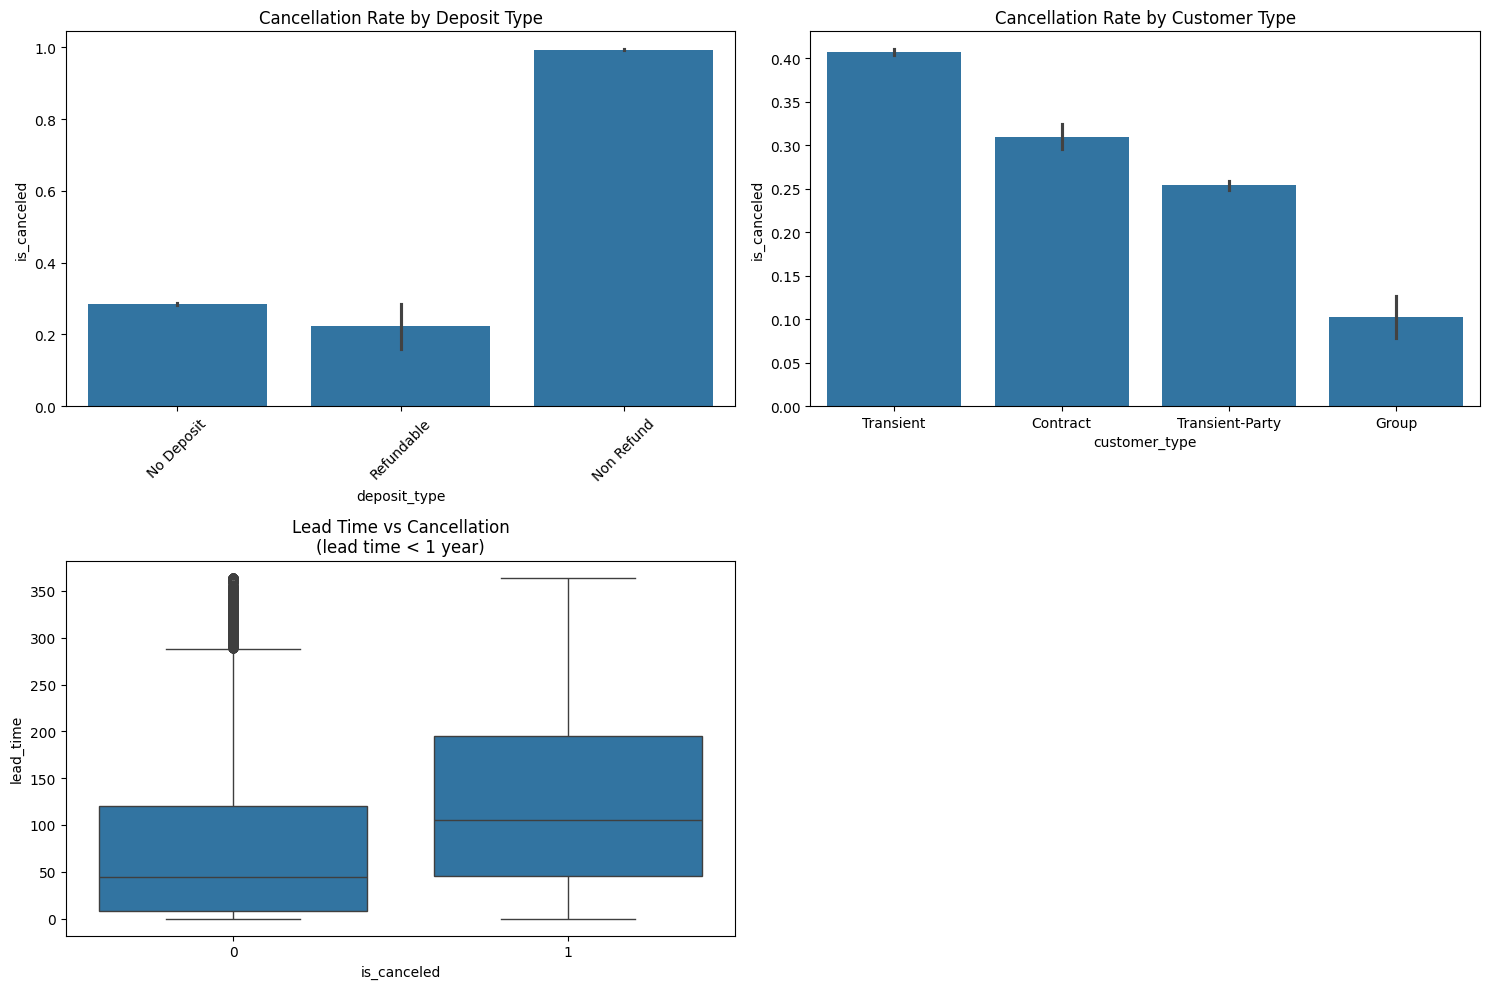

In [10]:
# Print deposit type and customer type statistics
print("\nCancellation rate by deposit type:")
print(df.groupby('deposit_type')['is_canceled'].mean().sort_values(ascending=False))

print("\nCancellation rate by customer type:")
print(df.groupby('customer_type')['is_canceled'].mean().sort_values(ascending=False))

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Cancellation rate by deposit type
plt.subplot(221)
sns.barplot(data=df, x='deposit_type', y='is_canceled')
plt.title('Cancellation Rate by Deposit Type')
plt.xticks(rotation=45)

# Plot 2: Cancellation rate by customer type
plt.subplot(222)
sns.barplot(data=df, x='customer_type', y='is_canceled')
plt.title('Cancellation Rate by Customer Type')

# Plot 3: Lead time distribution by cancellation
plt.subplot(223)
sns.boxplot(data=df[df['lead_time'] < 365], x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation\n(lead time < 1 year)')

plt.tight_layout()
plt.show()

Cancellation Rate by Deposit Type:
- Non Refund bookings have a very high cancellation rate (99.4%), which may seem counterintuitive, as one would expect customers who paid non-refundable deposits to commit to their reservations. This could indicate that customers make non-refundable bookings with a lower commitment (perhaps due to discounted rates), or it might suggest a specific pattern of behavior that could vary by market or customer type. It is also important to notice that this deposit type has far more less entries than the No Deposit type.
- No Deposit bookings have a moderate cancellation rate (28.4%). Without a financial commitment, customers may feel freer to cancel.
- Refundable bookings have the lowest cancellation rate (22.2%), which makes sense since customers can cancel if needed, reducing the need to preemptively book and cancel.

Cancellation Rate by Customer Type:
- Transient customers, who typically make single, short-term bookings, have the highest cancellation rate (40.7%). This aligns with their behavior, as transient customers might be more flexible and open to changes.
- Contract bookings have a slightly lower cancellation rate (30.9%). This group might have semi-committed bookings but still faces some variability.
- Transient-Party (transient customers booking with a group) have a moderate cancellation rate (25.4%), potentially because these bookings may involve multiple people or families with stronger commitments.
- Group bookings have the lowest cancellation rate (10.2%). These bookings, likely involving large groups or events, are often planned well in advance, making cancellations less likely.

Lead Time vs Cancellation:
- The boxplot reveals that bookings with shorter lead times are, on average, less likely to be canceled.

# Data Preparation

## Outlier Removal

In [68]:
# Function to count outliers in numerical columns.
def count_outliers(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for column in num_cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f'Number of outliers in {column}: {outliers.shape[0]}')

# removing outliers on numerical columns
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
# Select numerical columns to remove outliers
numerical_columns = numerical_columns.drop(['is_canceled', 'agent', 'company', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
                                            'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces'])

print("\nNumerical columns to remove the outliers from:")
print(numerical_columns)




Numerical columns to remove the outliers from:
Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adr', 'total_of_special_requests'],
      dtype='object')


In [ ]:
# Check the number of outliers in the numerical columns
count_outliers(df)

Number of outliers in is_canceled: 0
Number of outliers in lead_time: 3005
Number of outliers in arrival_date_year: 0
Number of outliers in arrival_date_week_number: 0
Number of outliers in arrival_date_day_of_month: 0
Number of outliers in stays_in_weekend_nights: 265
Number of outliers in stays_in_week_nights: 3354
Number of outliers in adults: 29710
Number of outliers in children: 8590
Number of outliers in babies: 917
Number of outliers in is_repeated_guest: 3810
Number of outliers in previous_cancellations: 6484
Number of outliers in previous_bookings_not_canceled: 3620
Number of outliers in booking_changes: 18076
Number of outliers in agent: 0
Number of outliers in company: 0
Number of outliers in days_in_waiting_list: 3698
Number of outliers in adr: 3793
Number of outliers in required_car_parking_spaces: 7416
Number of outliers in total_of_special_requests: 2877


In [ ]:
# Remove outliers
for column in numerical_columns:
    df = remove_outliers(df, column)

count_outliers(df)
print(len(df))


Number of outliers in is_canceled: 0
Number of outliers in lead_time: 637
Number of outliers in arrival_date_year: 0
Number of outliers in arrival_date_week_number: 0
Number of outliers in arrival_date_day_of_month: 0
Number of outliers in stays_in_weekend_nights: 0
Number of outliers in stays_in_week_nights: 0
Number of outliers in adults: 27044
Number of outliers in children: 6103
Number of outliers in babies: 669
Number of outliers in is_repeated_guest: 3532
Number of outliers in previous_cancellations: 6061
Number of outliers in previous_bookings_not_canceled: 3317
Number of outliers in booking_changes: 15228
Number of outliers in agent: 653
Number of outliers in company: 0
Number of outliers in days_in_waiting_list: 3475
Number of outliers in adr: 975
Number of outliers in required_car_parking_spaces: 6341
Number of outliers in total_of_special_requests: 0
105305


## Feature Engineering

As said before, some of the features can be combined into one variable. In addition, new features can also be created from the existing data. The following feature engineering will be done:
- Combine the date-related features into one named 'arrival_date';
- Create a new feature named 'booking_date' based on the difference between 'arrival_date' with 'lead_time';
- Create a new feature named 'is_weekend_arrival' based in the arrival_date;
- Combine the stays-related features into one named 'total_nights';
- Combine the 'adults', 'children' and 'babies' into one named 'total_guests';
- Combine the 'reserved_room_type' and 'assigned_room_type' into one named 'got_desired_room';
- Create a new feature named 'season' based on the month of arrival.

It was also detected a number of missing values in the following features which will be treated ahead:
- 'children'; 
- 'country';
- 'agent';
- 'company'.

We decided not to remove any entry with a missing value as it could mean a loss of predictive data for the models, despite, for example 'children' only has 4 missing values.

In [14]:
# Create feature engineering pipeline
def engineer_features(df):
    # Create copy to avoid modifying original
    df_proc = df.copy()
    
    # Temporal features
    df_proc['arrival_date'] = pd.to_datetime(df_proc['arrival_date_year'].astype(str) + '-' + 
                                           df_proc['arrival_date_month'] + '-' + 
                                           df_proc['arrival_date_day_of_month'].astype(str))
    df_proc['booking_date'] = df_proc['arrival_date'] - pd.to_timedelta(df_proc['lead_time'], unit='D')
    df_proc['is_weekend_arrival'] = df_proc['arrival_date'].dt.dayofweek >= 5
    
    # Aggregate features
    df_proc['total_nights'] = df_proc['stays_in_weekend_nights'] + df_proc['stays_in_week_nights']
    df_proc['total_guests'] = df_proc['adults'] + df_proc['children'].fillna(0) + df_proc['babies']
    
    # Room type match
    df_proc['got_desired_room'] = (df_proc['reserved_room_type'] == df_proc['assigned_room_type']).astype(int)
    
    # Season feature
    conditions = [
        df_proc['arrival_date_month'].isin(['December', 'January', 'February']),
        df_proc['arrival_date_month'].isin(['March', 'April', 'May']),
        df_proc['arrival_date_month'].isin(['June', 'July', 'August']),
        df_proc['arrival_date_month'].isin(['September', 'October', 'November'])
    ]
    choices = ['winter', 'spring', 'summer', 'fall']
    df_proc['season'] = np.select(conditions, choices, default='unknown')
    
    # Drop unnecessary columns
    cols_to_drop = ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                    'arrival_date_week_number', 'arrival_date', 'reservation_status', 
                    'reservation_status_date']
    
    return df_proc.drop(columns=cols_to_drop)

# Handle missing values
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Fill missing values
    df_clean['children'] = df_clean['children'].fillna(0)
    df_clean['country'] = df_clean['country'].fillna('Unknown')
    df_clean['agent'] = df_clean['agent'].fillna(0)
    df_clean['company'] = df_clean['company'].fillna(0)
    
    return df_clean

# Run preprocessing
print("Starting preprocessing...")
df_processed = engineer_features(df)
df_processed = handle_missing_values(df_processed)

# Show resulting features
print("\nProcessed features:")
print(df_processed.columns.tolist())

# Show sample of engineered features
print("\nSample of engineered features:")
print(df_processed[['booking_date', 'is_weekend_arrival', 'total_nights', 
                   'total_guests', 'got_desired_room', 'season']].head())

Starting preprocessing...

Processed features:
['hotel', 'is_canceled', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'booking_date', 'is_weekend_arrival', 'total_nights', 'total_guests', 'got_desired_room', 'season']

Sample of engineered features:
  booking_date  is_weekend_arrival  total_nights  total_guests  \
0   2014-07-24               False             0           2.0   
2   2015-06-24               False             1           1.0   
3   2015-06-18               False             1           1.0   
4   2015-06-17               False             2           2.0   
5   2015-06-17       

In [15]:
# Check if variables that are not supposed to have zero values have zero values
print("Number of rows where total_guests is 0:", (df_processed['total_guests'] == 0).sum())
print("Number of rows where total_nights is 0:", (df_processed['total_nights'] == 0).sum())

Number of rows where total_guests is 0: 147
Number of rows where total_nights is 0: 701


The zeros in 'total_nights' might be explained by during-the-day-only stays, where guests didn't spent the night. The zeros in the 'total_guests' are a strange occurance but since there are so few instances we decided not to do anything.

In [16]:
# Calculate correlations correctly
numerical_cols = ['lead_time', 'total_nights', 'total_guests', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests',
                 'previous_cancellations', 'previous_bookings_not_canceled']

correlations = {col: df_processed['is_canceled'].corr(df_processed[col]) for col in numerical_cols}
print("\nCorrelations with cancellation:")
for col, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{col}: {corr:.3f}")


Correlations with cancellation:
lead_time: 0.304
total_of_special_requests: -0.229
required_car_parking_spaces: -0.191
previous_cancellations: 0.114
adr: 0.077
previous_bookings_not_canceled: -0.058
total_guests: 0.053
total_nights: 0.036


From the previous report we see a top 8 numerical features most correlated with the target. The coefficients are fairly small, indicating a relationship between the variables, but not very strong. 

Text(0.5, 1.0, 'Length of Stay vs Cancellation\n(stays < 15 nights)')

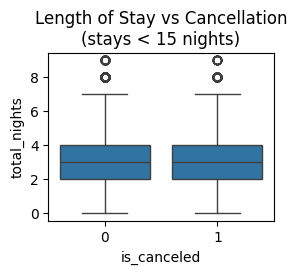

In [17]:
# Plot 3: Total nights distribution for cancelled vs non-cancelled
plt.subplot(223)
sns.boxplot(data=df_processed[df_processed['total_nights'] < 15], x='is_canceled', y='total_nights')
plt.title('Length of Stay vs Cancellation\n(stays < 15 nights)')

From the previous boxplot we see that there is not much or any difference at all between the distribution of the length of stay when smaller than 15 days. 

is_canceled      0      1  total  cancellation_rate
season                                             
fall         16306   9275  25581           0.362574
spring       18879  11251  30130           0.373415
summer       18378  11925  30303           0.393525
winter       13137   6154  19291           0.319009


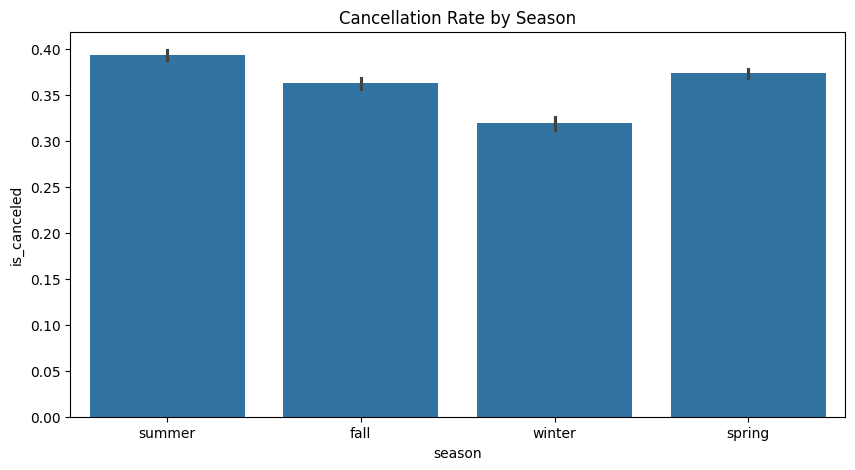

In [18]:
# Check cancellation rate of bookings by season
df_season = df_processed.groupby(['season', 'is_canceled']).size().unstack()
df_season['total'] = df_season.sum(axis=1)
df_season['cancellation_rate'] = df_season[1] / df_season['total']
print(df_season)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_processed, x='season', y='is_canceled')
plt.title('Cancellation Rate by Season')
plt.show()

From the above report it is possible to see that the cancellation rates by season do not vary much. The smallest rate happens in winter but since the difference is small, we can't infere a strong relationship.

## Feature Selection

Since our target variable, depiste numerical, is categorical, the following feature selection algorithms will be performed:
- Chi: to analyse the correlation of the target and the categorical features;
- ANOVA: to analyse the correlation of the target and the continuous features; 
- Lasso;
- Feature importance from decision trees (Random Forest algorithm) 

### Chi

In [19]:
categorical_cols = df_processed.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'is_weekend_arrival',
 'season']

In [20]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [21]:
FunctionChisq(inpData=df_processed, TargetVariable='is_canceled', CategoricalVariablesList=categorical_cols)

hotel is correlated with is_canceled | P-Value: 0.0
meal is correlated with is_canceled | P-Value: 1.4569353892756737e-66
country is correlated with is_canceled | P-Value: 0.0
market_segment is correlated with is_canceled | P-Value: 0.0
distribution_channel is correlated with is_canceled | P-Value: 0.0
reserved_room_type is correlated with is_canceled | P-Value: 2.3628281930819817e-101
assigned_room_type is correlated with is_canceled | P-Value: 0.0
deposit_type is correlated with is_canceled | P-Value: 0.0
customer_type is correlated with is_canceled | P-Value: 0.0
is_weekend_arrival is NOT correlated with is_canceled | P-Value: 0.3680108299043874
season is correlated with is_canceled | P-Value: 1.0839868190517814e-62


['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'season']

According to Chi, all of the categorical features are correlated to the target. Here are the categorical features sorted from highest P-value to lowest:
- is_weekend_arrival;
- season;
- meal;
- reserved_room_type;
- distribution_channel (after this point all the features had P-value 0 so they are not in any particular order);
- market_segment;
- hotel;
- country;
- assigned_room_type;
- deposit_type;
- customer_type.

We conclude that none of the categorical features shall be removed.

### ANOVA

In [22]:

def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [23]:
# Select numerical columns
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('is_canceled')
numerical_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'total_guests']

In [24]:
FunctionAnova(inpData=df_processed, TargetVariable='is_canceled', ContinuousPredictorList=numerical_cols)

##### ANOVA Results ##### 

lead_time is correlated with is_canceled | P-Value: 0.0
stays_in_weekend_nights is correlated with is_canceled | P-Value: 0.01657354565869004
stays_in_week_nights is correlated with is_canceled | P-Value: 4.479154997712977e-40
adults is correlated with is_canceled | P-Value: 8.04838243305394e-103
children is NOT correlated with is_canceled | P-Value: 0.6858101472089937
babies is correlated with is_canceled | P-Value: 6.9525226439468015e-22
is_repeated_guest is correlated with is_canceled | P-Value: 3.3832223881657163e-165
previous_cancellations is correlated with is_canceled | P-Value: 8.927085376662705e-304
previous_bookings_not_canceled is correlated with is_canceled | P-Value: 1.8048092477332036e-78
booking_changes is correlated with is_canceled | P-Value: 0.0
agent is correlated with is_canceled | P-Value: 7.180355308729423e-67
company is correlated with is_canceled | P-Value: 1.9768092876710305e-163
days_in_waiting_list is correlated with is_canceled | 

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'total_guests']

According to ANOVA, 'children' and 'stays_in_weekend_nights' are not correlated to the target variable, meaning that they can be removed.

### Lasso

To perform Lasso Regularization a processing of the data is necessary. So the encoding of the categorical features will be done and the scalling of the numeric for a better models performance.

In [25]:
# Select binary features
binary_feaures = df_processed.nunique()[df_processed.nunique() == 2].keys().tolist()
binary_feaures

['hotel',
 'is_canceled',
 'is_repeated_guest',
 'is_weekend_arrival',
 'got_desired_room']

Off of all the binary features, only the 'hotel' is categorical so this is the only one that needs the Binary Encoding

In [26]:
# Replace hotel with 0 and 1
df_processed['hotel'] = df_processed['hotel'].map({'Resort Hotel': 0, 'City Hotel': 1})

In [ ]:
# Use One-Hot encoding for the remaining categorical features
df_processed_encoded = pd.get_dummies(df_processed, drop_first=True)
df_processed_encoded.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0,0,342,0,0,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
2,0,0,7,0,1,1,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
3,0,0,13,0,1,1,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
4,0,0,14,0,2,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
5,0,0,14,0,2,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False


In [28]:
# Drop booking_date
df_processed_encoded = df_processed_encoded.drop(columns=['booking_date'])

In [ ]:
# Scale the numerical features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_processed_encoded_scaled = scaler.fit_transform(df_processed_encoded)
df_processed_encoded_scaled = pd.DataFrame(df_processed_encoded_scaled, columns=df_processed_encoded.columns)
df_processed_encoded_scaled

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.0,0.2,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.0,0.2,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.0,0.4,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.0,0.4,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105300,1.0,0.0,0.362903,0.5,0.8,0.054545,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105301,1.0,0.0,0.440860,0.5,0.8,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105302,1.0,0.0,0.056452,0.5,1.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105303,1.0,0.0,0.061828,0.5,1.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def lasso_regularization(df):

    X = df.iloc[:,:-1]          
    y = df.iloc[:,-1] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)

    # fit a Logistic Regression model and feature selection altogether 
    # select the Lasso (l1) penalty.
    # The selectFromModel class from sklearn, selects the features which coefficients are non-zero

    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

    sel_.fit(scaler.transform(X_train), y_train)

    # make a list with the selected features
    selected_feat = X_train.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(sel_.estimator_.coef_ == 0))
    # identify the removed features like this:
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print(removed_feats) 

    # transform data
    X_lasso = pd.DataFrame(sel_.transform(scaler.transform(X)), columns=selected_feat)
    
    return X_lasso

In [31]:
lasso_regularization(df_processed_encoded_scaled)

Number of features which coefficient was shrank to zero:  43
Index(['adults', 'total_nights', 'country_ATF', 'country_BDI', 'country_BEN',
       'country_BHR', 'country_BHS', 'country_BOL', 'country_BRB',
       'country_CUB', 'country_DMA', 'country_FJI', 'country_FRO',
       'country_IMN', 'country_KHM', 'country_KIR', 'country_LAO',
       'country_MLI', 'country_MRT', 'country_MYT', 'country_NAM',
       'country_NCL', 'country_NIC', 'country_NPL', 'country_PLW',
       'country_PRT', 'country_PRY', 'country_QAT', 'country_SDN',
       'country_SLE', 'country_SLV', 'country_STP', 'country_SUR',
       'country_SYC', 'country_TJK', 'country_TWN', 'country_UMI',
       'country_VGB', 'country_ZMB', 'market_segment_Undefined',
       'distribution_channel_Undefined', 'reserved_room_type_L',
       'assigned_room_type_L'],
      dtype='object')


,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer
0,-1.495009,-0.763017,2.664142,-0.976047,-1.641427,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
1,-1.495009,-0.763017,-0.941554,-0.976047,-0.907805,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
2,-1.495009,-0.763017,-0.876974,-0.976047,-0.907805,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
3,-1.495009,-0.763017,-0.866211,-0.976047,-0.174183,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
4,-1.495009,-0.763017,-0.866211,-0.976047,-0.174183,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105300,0.668892,-0.763017,0.436145,1.393547,1.293060,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105301,0.668892,-0.763017,0.748280,1.393547,1.293060,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105302,0.668892,-0.763017,-0.790868,1.393547,2.026682,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105303,0.668892,-0.763017,-0.769341,1.393547,2.026682,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534


From the Lasso Regularization, the features which coefficient was shrank to zero will be removed from the dataset.

### Feature importance from decision trees (Random Forest algorithm) 

Training model...

Making predictions...


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     13345
           1       0.87      0.81      0.84      7716

    accuracy                           0.89     21061
   macro avg       0.88      0.87      0.88     21061
weighted avg       0.89      0.89      0.89     21061


ROC-AUC Score: 0.955


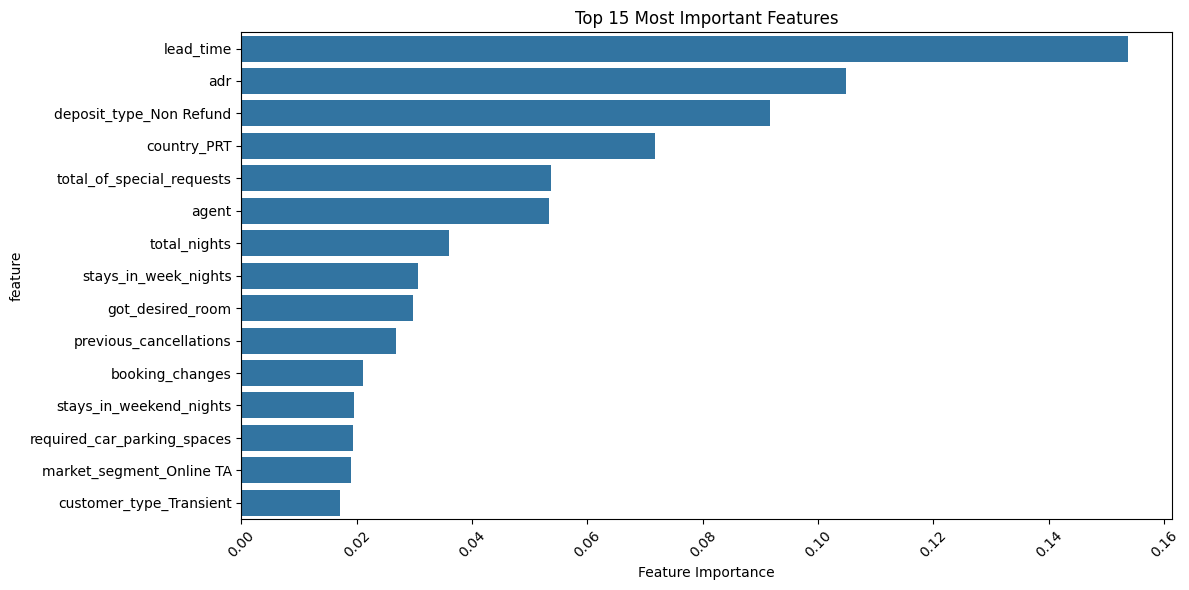


Top 10 Most Important Features:
                       feature  importance
0                    lead_time    0.153665
13                         adr    0.104809
223    deposit_type_Non Refund    0.091730
152                country_PRT    0.071720
15   total_of_special_requests    0.053753
10                       agent    0.053364
16                total_nights    0.035922
2         stays_in_week_nights    0.030539
19            got_desired_room    0.029826
7       previous_cancellations    0.026726


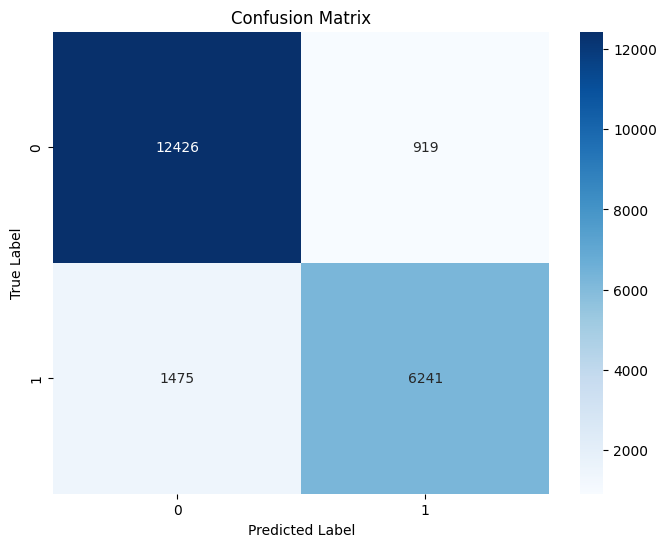


Model Performance Summary:
Total samples in test set: 21061
Correct predictions: 18667
Accuracy: 0.886

Detailed Metrics:
True Negatives (Correctly predicted non-cancellations): 12426
False Positives (Incorrectly predicted cancellations): 919
False Negatives (Missed cancellations): 1475
True Positives (Correctly predicted cancellations): 6241
Precision (Of predicted cancellations, what fraction were actual cancellations): 0.872
Recall (Of actual cancellations, what fraction were caught): 0.809


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Separate features and target
X = df_processed.drop('is_canceled', axis=1)
y = df_processed['is_canceled']

# Split categorical and numerical columns
categorical_features = ['hotel', 'meal', 'country', 'market_segment', 
                       'distribution_channel', 'reserved_room_type',
                       'assigned_room_type', 'deposit_type', 'customer_type']
numerical_features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                     'adults', 'children', 'babies', 'is_repeated_guest',
                     'previous_cancellations', 'previous_bookings_not_canceled',
                     'booking_changes', 'agent', 'company', 'days_in_waiting_list',
                     'adr', 'required_car_parking_spaces', 'total_of_special_requests',
                     'total_nights', 'total_guests', 'is_weekend_arrival', 'got_desired_room']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
print("Training model...")
model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print model performance
print("\nModel Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(categorical_feature_names)

# Calculate feature importance
feature_importance = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some additional insights
print("\nModel Performance Summary:")
print(f"Total samples in test set: {len(y_test)}")
print(f"Correct predictions: {(y_pred == y_test).sum()}")
print(f"Accuracy: {(y_pred == y_test).mean():.3f}")

# Calculate class-wise metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (Correctly predicted non-cancellations): {tn}")
print(f"False Positives (Incorrectly predicted cancellations): {fp}")
print(f"False Negatives (Missed cancellations): {fn}")
print(f"True Positives (Correctly predicted cancellations): {tp}")
print(f"Precision (Of predicted cancellations, what fraction were actual cancellations): {tp/(tp+fp):.3f}")
print(f"Recall (Of actual cancellations, what fraction were caught): {tp/(tp+fn):.3f}")

# Modeling

The modeling will be performed using the three datasets: a dataset result of the feature selection done by the filter methods, a dataset result of the Lasso Regularization and a dataset result of the Random Forest Algorithm.

In [33]:
# Create the dataset according to the filter methods
df_filter = df_processed_encoded_scaled.drop(columns=['children', 'stays_in_weekend_nights'])
df_filter.head()

,hotel,is_canceled,lead_time,stays_in_week_nights,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.036364,0.0,0.0,0.0,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.2,0.018182,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.2,0.018182,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.4,0.036364,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.4,0.036364,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Drop the columns that were removed by the Lasso regularization
df_lasso = df_processed_encoded_scaled.drop(columns=['adults', 'total_nights', 'country_ATF', 'country_BDI', 'country_BEN',
       'country_BHR', 'country_BHS', 'country_BOL', 'country_BRB',
       'country_CUB', 'country_DMA', 'country_FJI', 'country_FRO',
       'country_IMN', 'country_KHM', 'country_KIR', 'country_LAO',
       'country_MLI', 'country_MRT', 'country_MYT', 'country_NAM',
       'country_NCL', 'country_NIC', 'country_NPL', 'country_PLW',
       'country_PRT', 'country_PRY', 'country_QAT', 'country_SDN',
       'country_SLE', 'country_SLV', 'country_STP', 'country_SUR',
       'country_SYC', 'country_TJK', 'country_TWN', 'country_UMI',
       'country_VGB', 'country_ZMB', 'market_segment_Undefined',
       'distribution_channel_Undefined', 'reserved_room_type_L',
       'assigned_room_type_L'])
df_lasso.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Drop the columns that were removed by the Random Forest feature importance
df_random_forest = df_processed_encoded_scaled[['lead_time', 'adr', 'deposit_type_Non Refund', 
                                               'country_PRT', 'total_of_special_requests', 'agent', 
                                               'total_nights', 'stays_in_week_nights', 'previous_cancellations', 
                                               'got_desired_room', 'is_canceled']]
df_random_forest.head()

,lead_time,adr,deposit_type_Non Refund,country_PRT,total_of_special_requests,agent,total_nights,stays_in_week_nights,previous_cancellations,got_desired_room,is_canceled
0,0.919355,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0
1,0.018817,0.357381,0.0,0.0,0.0,0.000000,0.111111,0.2,0.0,0.0,0.0
2,0.034946,0.357381,0.0,0.0,0.0,0.568224,0.111111,0.2,0.0,1.0,0.0
3,0.037634,0.466978,0.0,0.0,0.5,0.448598,0.222222,0.4,0.0,1.0,0.0
4,0.037634,0.466978,0.0,0.0,0.5,0.448598,0.222222,0.4,0.0,1.0,0.0


For this particular dataset, since the target variable is slightly imbalanced, the Accuracy might not give the best insights about the models performance, since it can appear high simply by predicting the majority class most of the time, while completely neglecting the minority class.

Precision emphasizes minimizing false positives, which is important when the cost of incorrect positive predictions is high.
Recall focuses on minimizing false negatives, which is critical when it’s more important to capture all positive cases (even at the expense of some false positives).

The F1-score gives us a single metric that balances the trade-off between Precision and Recall. In an imbalanced dataset, this is especially valuable because it ensures that neither the positive nor the negative classes are ignored by the model. F1 is particularly useful when both false positives and false negatives are important to minimize.

For these reasons, the F1-score was chosen as the evaluation metric for the models.


In [36]:
# Define X and Y for each dataset
X_filter = df_filter.drop('is_canceled', axis=1)
y_filter = df_filter['is_canceled']

X_lasso = df_lasso.drop('is_canceled', axis=1)
y_lasso = df_lasso['is_canceled']

X_random_forest = df_random_forest.drop('is_canceled', axis=1)
y_random_forest = df_random_forest['is_canceled']

## KNN

In [37]:
# Do grid search for hyperparameter tuning for KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

knn_models = []

# Create the parameter grid
param_grid = {'n_neighbors': [3,5], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}

# Create the model
model = KNeighborsClassifier()

# Create grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search for each dataset
grid_search.fit(X_filter, y_filter)
print("Best Parameters Filter:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Filter', grid_search.best_estimator_))

grid_search.fit(X_lasso, y_lasso)
print("Best Parameters Lasso:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Lasso', grid_search.best_estimator_))

grid_search.fit(X_random_forest, y_random_forest)
print("Best Parameters Random Forest:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Random Forest', grid_search.best_estimator_))

Best Parameters Filter:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8479690491075453
Best Parameters Lasso:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8405383897472557
Best Parameters Random Forest:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8348998489796816


## Naïve Bayes 

In [38]:
from sklearn.naive_bayes import GaussianNB
naiveBayes_models = []

# Create the model
gaussianNB = GaussianNB()

## Ensemble Learning

In [39]:
from sklearn.ensemble import VotingClassifier

# Create the estimators list to store de models of each feature selection method
estimators_filter = []
estimators_lasso = []
estimators_random_forest = []

estimators_filter.append(('KNN', knn_models[0][1]))
estimators_filter.append(('Naive Bayes', gaussianNB))

estimators_lasso.append(('KNN', knn_models[1][1]))
estimators_lasso.append(('Naive Bayes', gaussianNB))

estimators_random_forest.append(('KNN', knn_models[2][1]))
estimators_random_forest.append(('Naive Bayes', gaussianNB))

# Create the ensemble model
ensemble_filter = VotingClassifier(estimators_filter, voting='soft')
ensemble_lasso = VotingClassifier(estimators_lasso, voting='soft')
ensemble_random_forest = VotingClassifier(estimators_random_forest, voting='soft')

ensemble_models = [('Filter', ensemble_filter), ('Lasso', ensemble_lasso), ('Random Forest', ensemble_random_forest)]

## Neural Networks

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.metrics import F1Score

import tensorflow as tf

# Function to create MLP network 

def nnetClassif (inputDim, optimizer, neurons):
       
    # Initialize the Sequential model
    model = Sequential()
    
    model.add(Input(shape=(inputDim,)))
    
    model.add(Dense(units=neurons, 
                    kernel_initializer='uniform', 
                    activation='relu'))    
    
    model.add(Dense(units=neurons, 
                    kernel_initializer='uniform', 
                    activation='relu'))    
    
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))  
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(average=None, threshold=None, name="f1_score", dtype=None)])
            
    return model


In [60]:
# Do holdout for grid search for hyperparameter tuning for MLP
from sklearn.model_selection import train_test_split

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y_filter, test_size=0.2, random_state=42)
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42)
X_train_random_forest, X_test_random_forest, y_train_random_forest, y_test_random_forest = train_test_split(X_random_forest, y_random_forest, test_size=0.2, random_state=42)


In [61]:
# Creating the classifier ANN
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

nn_models = []

#for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

input_dim = X_train_filter.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_filter, y_train_filter, validation_split=0.1, verbose=-1)

EndTime=time.time()

nn_models.append(('Filter', grid_result.best_estimator_))


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [62]:
input_dim = X_train_lasso.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_lasso, y_train_lasso, validation_split=0.1, verbose=-1)

EndTime=time.time()
nn_models.append(('Lasso', grid_result.best_estimator_))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [63]:
input_dim = X_train_random_forest.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_random_forest, y_train_random_forest, validation_split=0.1, verbose=-1)

EndTime=time.time()
best_nn_random_forest = grid_result.best_estimator_
nn_models.append(('Random Forest', best_nn_random_forest))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

# Model Evaluation

The holdout will be the method chosen to perform the evaluation of the methods, since the given dataset is a large one and methods like Cross Validation, Leave One Out and Bootstrap are more suitable for smaller datasets.

## KNN


Filter:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     13340
         1.0       0.80      0.78      0.79      7721

    accuracy                           0.85     21061
   macro avg       0.84      0.83      0.83     21061
weighted avg       0.85      0.85      0.85     21061



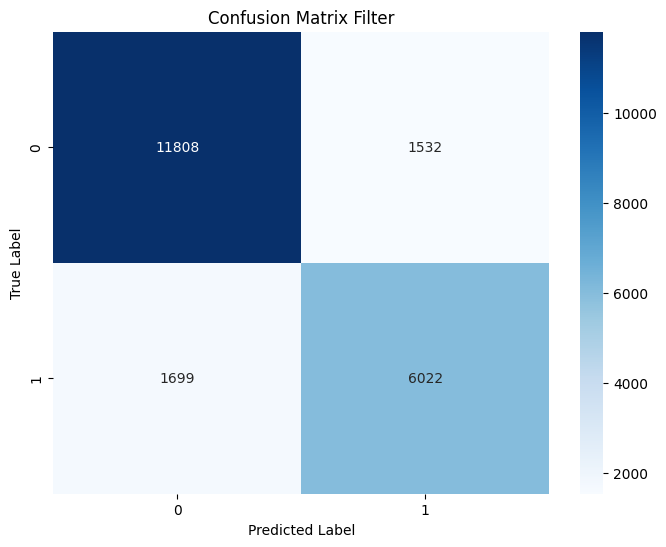


Lasso:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     13340
         1.0       0.78      0.78      0.78      7721

    accuracy                           0.84     21061
   macro avg       0.83      0.83      0.83     21061
weighted avg       0.84      0.84      0.84     21061



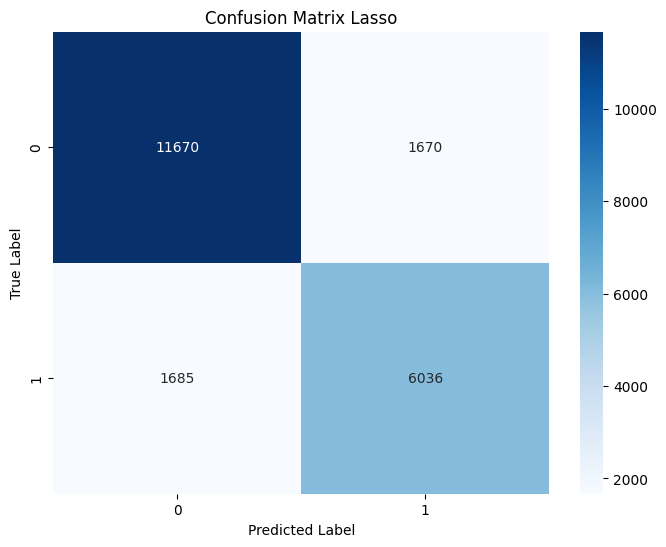


Random Forest:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     13340
         1.0       0.79      0.76      0.78      7721

    accuracy                           0.84     21061
   macro avg       0.83      0.82      0.82     21061
weighted avg       0.84      0.84      0.84     21061



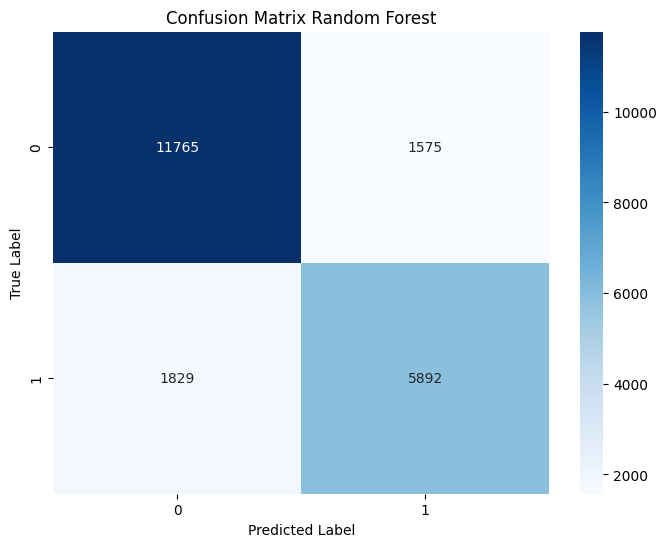

In [64]:
# Do holdout validation for the models
from sklearn.model_selection import train_test_split

# Split the data
X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y_filter, test_size=0.2, random_state=42, stratify=y_filter)
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42, stratify=y_lasso)
X_train_random_forest, X_test_random_forest, y_train_random_forest, y_test_random_forest = train_test_split(X_random_forest, y_random_forest, test_size=0.2, random_state=42, stratify=y_random_forest)

# Evaluate the models
from sklearn.metrics import classification_report

for name, model in knn_models:
    if name == 'Filter':
        X_train = X_train_filter
        y_train = y_train_filter
        X_test = X_test_filter
        y_test = y_test_filter
    elif name == 'Lasso':
        X_train = X_train_lasso
        y_train = y_train_lasso
        X_test = X_test_lasso
        y_test = y_test_lasso
    else:
        X_train = X_train_random_forest
        y_train = y_train_random_forest
        X_test = X_test_random_forest
        y_test = y_test_random_forest
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


From the weighted f1 score results of the model testing:
- Filter: 0.85;
- Lasso: 0.84;
- Random Forest: 0.84;

We conclude that, for the KNN model, there was not much difference between the feature selection done. Nevertheless, the filter methods gave a better set of features for the KNN model, scoring the highest f1 score.

## Naïve Bayes 


Filter:
              precision    recall  f1-score   support

         0.0       0.94      0.16      0.27     13340
         1.0       0.40      0.98      0.57      7721

    accuracy                           0.46     21061
   macro avg       0.67      0.57      0.42     21061
weighted avg       0.74      0.46      0.38     21061



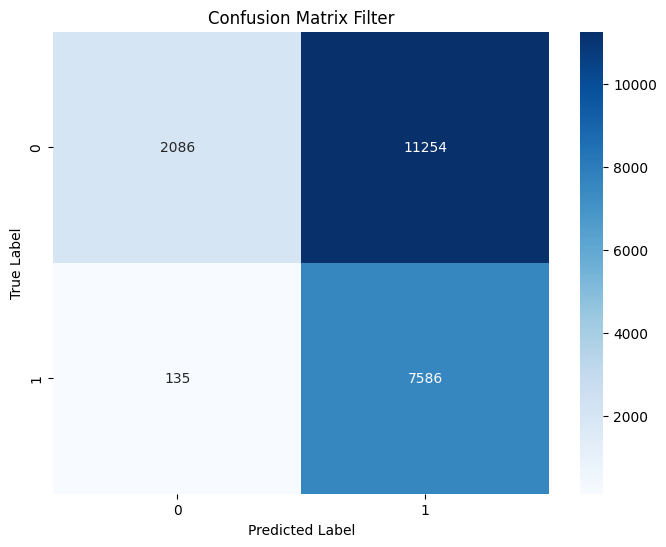


Lasso:
              precision    recall  f1-score   support

         0.0       0.93      0.17      0.29     13340
         1.0       0.41      0.98      0.57      7721

    accuracy                           0.47     21061
   macro avg       0.67      0.57      0.43     21061
weighted avg       0.74      0.47      0.39     21061



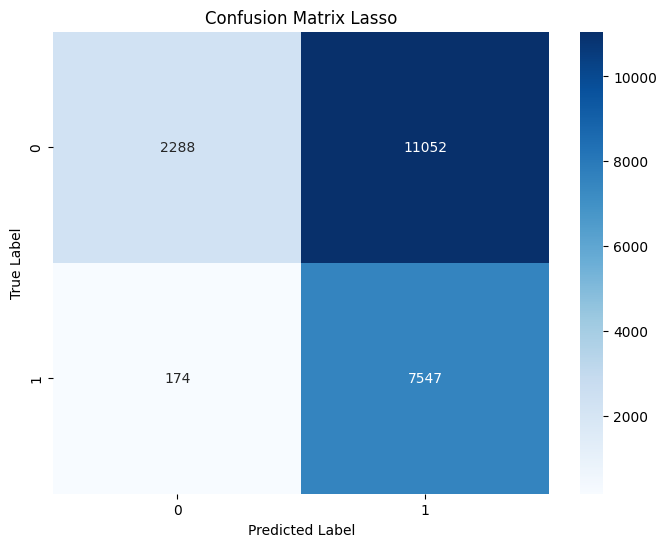


Random Forest:
              precision    recall  f1-score   support

         0.0       0.74      0.99      0.85     13340
         1.0       0.97      0.39      0.56      7721

    accuracy                           0.77     21061
   macro avg       0.85      0.69      0.70     21061
weighted avg       0.82      0.77      0.74     21061



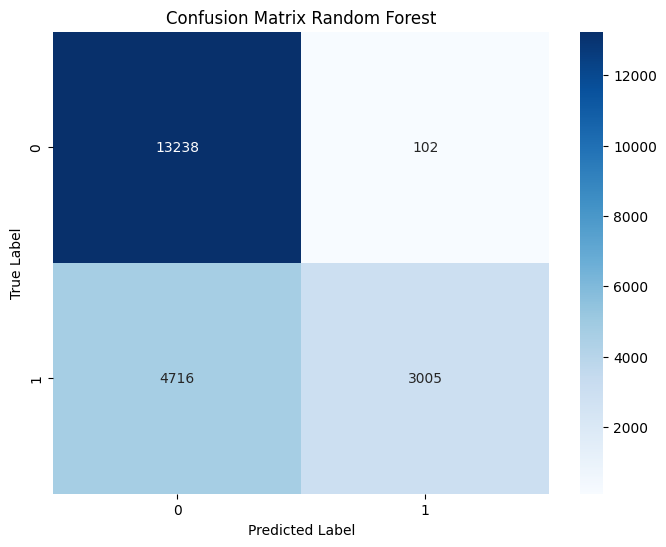

In [65]:
nb_models = ['Filter', 'Lasso', 'Random Forest']

for name in nb_models:
    if name == 'Filter':
        X_train = X_train_filter
        y_train = y_train_filter
        X_test = X_test_filter
        y_test = y_test_filter
    elif name == 'Lasso':
        X_train = X_train_lasso
        y_train = y_train_lasso
        X_test = X_test_lasso
        y_test = y_test_lasso
    else:
        X_train = X_train_random_forest
        y_train = y_train_random_forest
        X_test = X_test_random_forest
        y_test = y_test_random_forest
        
    gaussianNB.fit(X_train, y_train)
    y_pred = gaussianNB.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

From the weighted f1 score results of the model testing:
- Filter: 0.38;
- Lasso: 0.39;
- Random Forest: 0.74;

We conclude that, for the Naive Bayes model, there was not much difference between the Filter and Lasso feature selection (0.38 and 0.39, respectively), but the Random Forest Algorithm had a great improvement, scoring at 0.74 and beeing the best feature selection method for the Naive Bayes model.

## Ensemble Learning


Filter:
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78     13340
         1.0       0.62      0.93      0.74      7721

    accuracy                           0.76     21061
   macro avg       0.78      0.80      0.76     21061
weighted avg       0.82      0.76      0.77     21061



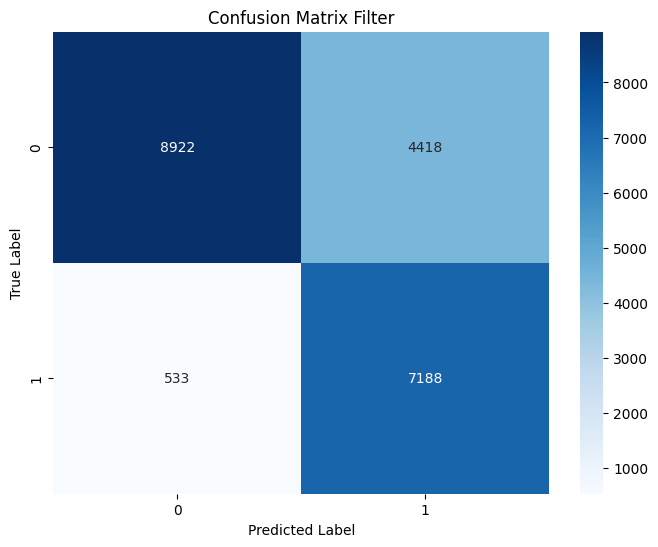


Lasso:
              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77     13340
         1.0       0.61      0.93      0.73      7721

    accuracy                           0.75     21061
   macro avg       0.77      0.79      0.75     21061
weighted avg       0.82      0.75      0.76     21061



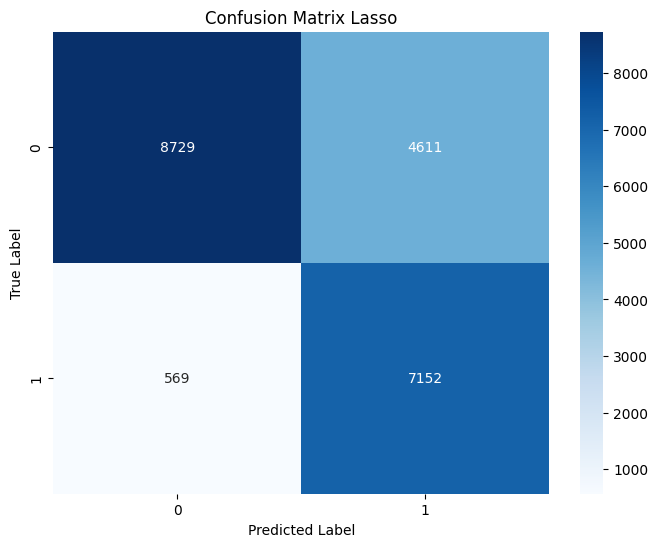


Random Forest:
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89     13340
         1.0       0.94      0.60      0.74      7721

    accuracy                           0.84     21061
   macro avg       0.88      0.79      0.81     21061
weighted avg       0.86      0.84      0.83     21061



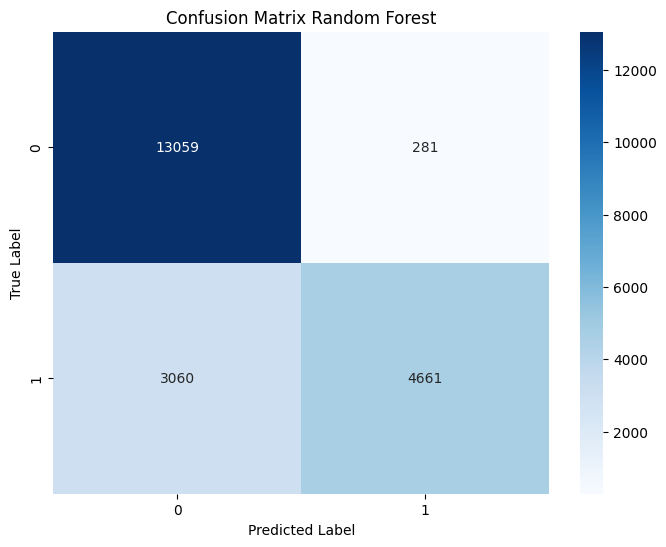

In [66]:
for name, model in ensemble_models:
    if name == 'Filter':
        X_train = X_train_filter
        y_train = y_train_filter
        X_test = X_test_filter
        y_test = y_test_filter
    elif name == 'Lasso':
        X_train = X_train_lasso
        y_train = y_train_lasso
        X_test = X_test_lasso
        y_test = y_test_lasso
    else:
        X_train = X_train_random_forest
        y_train = y_train_random_forest
        X_test = X_test_random_forest
        y_test = y_test_random_forest
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

From the weighted f1 score results of the model testing:
- Filter: 0.77;
- Lasso: 0.76;
- Random Forest: 0.83;

We conclude that, for the Ensemble model, there was again not much difference between the Filter methods and Lasso, but the Random Forest scored the highest (0.83), having a difference of 0.6 to Filter and 0.7 to Lasso.

## Neural Networks


Filter:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     13340
         1.0       0.86      0.72      0.78      7721

    accuracy                           0.85     21061
   macro avg       0.85      0.83      0.84     21061
weighted avg       0.85      0.85      0.85     21061



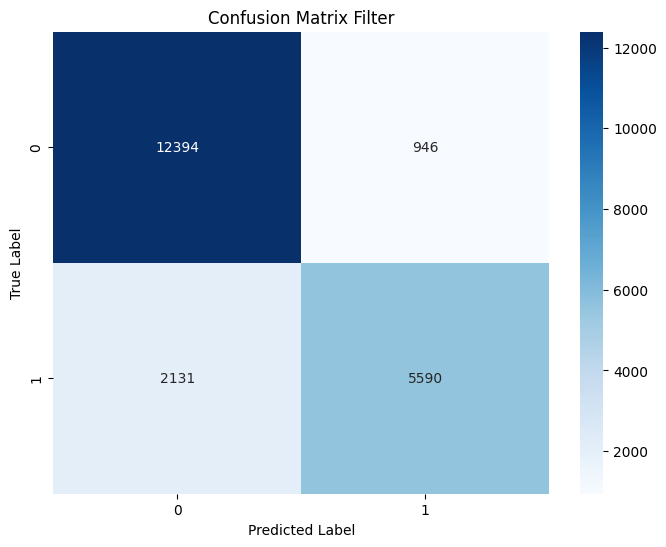


Lasso:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     13340
         1.0       0.86      0.72      0.78      7721

    accuracy                           0.85     21061
   macro avg       0.85      0.83      0.84     21061
weighted avg       0.85      0.85      0.85     21061



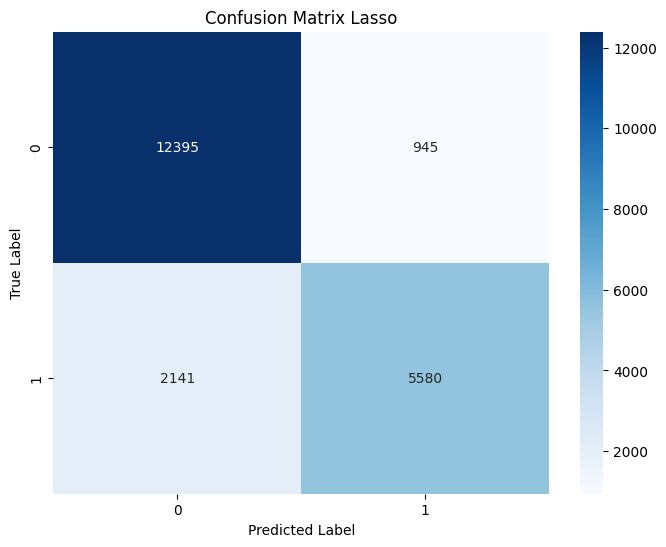


Random Forest:
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86     13340
         1.0       0.84      0.58      0.68      7721

    accuracy                           0.80     21061
   macro avg       0.81      0.76      0.77     21061
weighted avg       0.81      0.80      0.79     21061



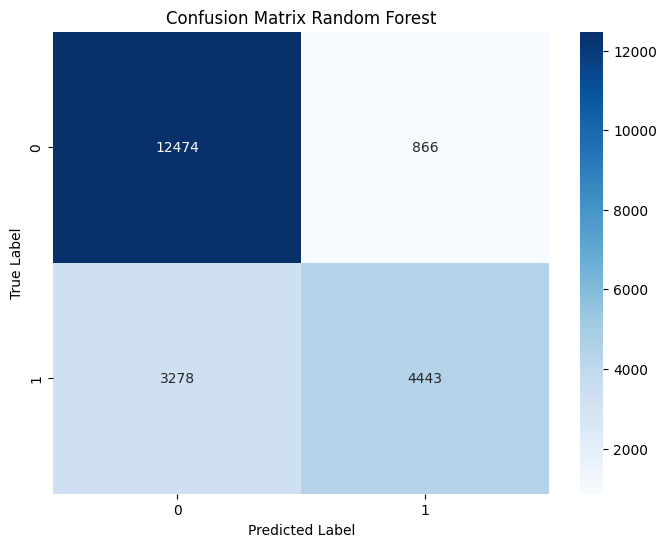

In [67]:
for name, model in nn_models:
    if name == 'Filter':
        X_train = X_train_filter
        y_train = y_train_filter
        X_test = X_test_filter
        y_test = y_test_filter
    elif name == 'Lasso':
        X_train = X_train_lasso
        y_train = y_train_lasso
        X_test = X_test_lasso
        y_test = y_test_lasso
    else:
        X_train = X_train_random_forest
        y_train = y_train_random_forest
        X_test = X_test_random_forest
        y_test = y_test_random_forest
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


From the weighted f1 score results of the model testing:
- Filter: 0.85;
- Lasso: 0.85;
- Random Forest: 0.79;

We conclude that, for the Neural Networks model, Filter and Lasso had the best scores (0.85) while the Random Forest scored the lowest (0.79).

## Models Conclusion

Taking into consideration all of the F1 scores achieved, we conclude that the overall best model was KNN, scoring 0.85 with the Filter methods and 0.84 with both Lasso and Random Forest. 

The worst model was Naive Bayes with 0.38 for Filter methods, 0.39 for Lasso and 0.74 for Random Forest.

The highest scoring models, with an weighted F1 score of 0.85 were KNN with Filter methods and Neural Networks with Filter methods and Lasso Regularization.

# Conclusion